In [2]:
import warnings
warnings.filterwarnings("ignore")

import os
import sys
import copy
import yaml
import tqdm
import torch
import pickle
import random
import joblib
import logging
import itertools
import numpy as np

from holodecml.torch.losses import *
from holodecml.torch.models import *
from holodecml.torch.trainers import *
from holodecml.torch.transforms import *
from holodecml.torch.optimizers import *
from holodecml.torch.data_loader import *

from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt

### Set up a logger

In [3]:
root = logging.getLogger()
root.setLevel(logging.DEBUG)
formatter = logging.Formatter('%(levelname)s:%(name)s:%(message)s')

# Stream output to stdout
ch = logging.StreamHandler()
ch.setLevel(logging.INFO)
ch.setFormatter(formatter)
root.addHandler(ch)

### Open a configuration

In [4]:
with open("model.yml") as config_file:
    conf = yaml.load(config_file, Loader=yaml.FullLoader)

### Load the device: CPU or GPU

In [5]:
device = torch.device(torch.cuda.current_device()) if torch.cuda.is_available() else torch.device("cpu")

In [6]:
device

device(type='cuda', index=0)

### Load the test data

In [7]:
train_transform = LoadTransformations(conf["train_transforms"], device = device)
valid_transform = LoadTransformations(conf["test_transforms"], device = device)

scaler_path = os.path.join(conf["trainer"]["path_save"], "scalers.save")

INFO:holodecml.torch.transforms:Loaded RandomVerticalFlip transformation with probability 0.5
INFO:holodecml.torch.transforms:Loaded RandomHorizontalFlip transformation with probability 0.5
INFO:holodecml.torch.transforms:Loaded Normalize transformation that scales pixel values between 0 to 1
INFO:holodecml.torch.transforms:Loaded ToTensor transformation, putting tensors on device cpu
INFO:holodecml.torch.transforms:Loaded Normalize transformation that scales pixel values between 0 to 1
INFO:holodecml.torch.transforms:Loaded ToTensor transformation, putting tensors on device cpu


In [8]:
train_gen = LoadReader(
    transform = train_transform,
    scaler = joblib.load(scaler_path) if os.path.isfile(scaler_path) else True,
    config = conf["train_data"]
)

if not os.path.isfile(scaler_path):
    joblib.dump(train_gen.scaler, scaler_path)

test_gen = LoadReader(
    transform = valid_transform, 
    scaler = joblib.load(scaler_path),
    config = conf["test_data"]
)

INFO:holodecml.torch.data_loader:Loading reader-type multi
INFO:holodecml.torch.data_loader:Loaded {'/glade/p/cisl/aiml/ai4ess_hackathon/holodec/synthetic_holograms_1particle_gamma_600x400_training.nc': 10000, '/glade/p/cisl/aiml/ai4ess_hackathon/holodec/synthetic_holograms_2particle_gamma_600x400_training.nc': 10000, '/glade/p/cisl/aiml/ai4ess_hackathon/holodec/synthetic_holograms_3particle_gamma_600x400_training.nc': 10000, '/glade/p/cisl/aiml/ai4ess_hackathon/holodec/synthetic_holograms_4particle_gamma_600x400_training.nc': 10000, '/glade/p/cisl/aiml/ai4ess_hackathon/holodec/synthetic_holograms_5particle_gamma_600x400_training.nc': 10000, '/glade/p/cisl/aiml/ai4ess_hackathon/holodec/synthetic_holograms_6particle_gamma_600x400_training.nc': 10000, '/glade/p/cisl/aiml/ai4ess_hackathon/holodec/synthetic_holograms_7particle_gamma_600x400_training.nc': 10000, '/glade/p/cisl/aiml/ai4ess_hackathon/holodec/synthetic_holograms_8particle_gamma_600x400_training.nc': 10000, '/glade/p/cisl/aiml/

### Load data iterators 

In [9]:
conf["test_iterator"]["batch_size"] = 1

test_dataloader = DataLoader(
    test_gen,
    **conf["test_iterator"]
)

### Load a pre-trained model

In [10]:
conf["model"]["weights"] = "/glade/work/schreck/repos/holodec-ml/scripts/schreck/vae/results/double_channel_0203/best.pt"

In [11]:
model = LoadModel(conf["model"])
model.build()
model = model.to(device)

INFO:holodecml.torch.models:Loading model-type att-vae with settings
INFO:holodecml.torch.models:image_channels: 1
INFO:holodecml.torch.models:out_image_channels: 2
INFO:holodecml.torch.models:hidden_dims: [114, 59, 34, 627, 544, 2000]
INFO:holodecml.torch.models:z_dim: 1014
INFO:holodecml.torch.models:weights: /glade/work/schreck/repos/holodec-ml/scripts/schreck/vae/results/double_channel_0203/best.pt
INFO:holodecml.torch.models.cnn:Loaded a self-attentive encoder-decoder VAE model
INFO:holodecml.torch.models.cnn:The model contains 198732538 trainable parameters
INFO:holodecml.torch.models.cnn:Loading weights from /glade/work/schreck/repos/holodec-ml/scripts/schreck/vae/results/double_channel_0203/best.pt


### Define a generator so we can predict and draw a hologram

In [12]:
def predict_generator(model):

    model.eval()
    with torch.no_grad():

        batch_size = test_dataloader.batch_size
        batches_per_epoch = int(np.ceil(test_gen.__len__() / batch_size))

        criterion = WeightedCrossEntropyLoss()

        epoch_losses = {"mse": [], "bce": [], "frac": [], 
                        "accuracy": [], "stop_accuracy": [], "seq_acc": []}

        for idx, images in enumerate(test_dataloader):
            images = images.to(device)
            with torch.no_grad():
                # Predict the latent vector and image reconstruction
                z, mu, logvar, encoder_att = model.encode(images)
                image_pred, decoder_att = model.decode(z)
                
                combined_att = torch.cat([
                    encoder_att[2].flatten(start_dim = 1),
                    decoder_att[0].flatten(start_dim = 1)
                ], 1)
                combined_att = combined_att.clone()

                encoder_att = [x.detach().cpu().numpy() for x in encoder_att]
                decoder_att = [x.detach().cpu().numpy() for x in decoder_att]
                
                if model.out_image_channels > 1:
                    z_real = np.sqrt(0.5) * image_pred[:,0,:,:]
                    z_imag = image_pred[:,1,:,:]
                    image_pred = torch.square(z_real) + torch.square(z_imag)
                    image_pred = torch.unsqueeze(image_pred, 1)
                
            images = torch.transpose(images.squeeze(0).squeeze(0), 1, 0).cpu().numpy()
            image_pred = torch.transpose(image_pred.squeeze(0).squeeze(0), 1, 0).cpu().numpy()
            
            yield (images, image_pred)

In [13]:
data_gen = predict_generator(model)

Text(0.5, 1.0, 'Predicted image')

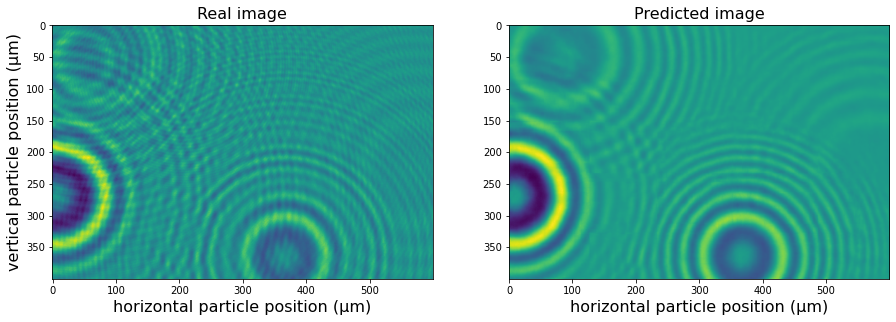

In [14]:
fs = 16

x, y = next(data_gen)

fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.imshow(x)
ax2.imshow(y)

ax1.set_xlabel("horizontal particle position (µm)", fontsize=fs)
ax2.set_xlabel("horizontal particle position (µm)", fontsize=fs)
ax1.set_ylabel("vertical particle position (µm)", fontsize=fs)

ax1.set_title("Real image", fontsize=fs)
ax2.set_title("Predicted image", fontsize=fs)